In [14]:
import pandas as pd
import tensorflow as tf
import numpy as np

df = pd.read_csv("Labels/classes.csv")

In [15]:
df.head()

,Unnamed: 0,photo_nr,target
0,0,CT_images\49_1.jpg,1
1,1,CT_images\49_2.jpg,1
2,2,CT_images\49_3.jpg,1
3,3,CT_images\49_4.jpg,1
4,4,CT_images\49_5.jpg,1


In [21]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=1)
  image = tf.image.resize(image, [650, 650])
  image /= 255.0  # normalize to [0,1] range


  return image
def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

In [22]:
all_image_paths = list(df['photo_nr'])
all_image_labels = list(df['target'])


ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

images = []
labels = []
for img, lab in ds:
  if lab == 0:
    images.append(img)
    labels.append(lab)
    
temp = tf.data.Dataset.from_tensor_slices((images, labels))

def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label


ds = ds.map(load_and_preprocess_from_path_label)


print(ds)


<MapDataset element_spec=(TensorSpec(shape=(650, 650, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>


In [23]:
ds_aug = temp.map(load_and_preprocess_from_path_label)
num_elements = tf.data.experimental.cardinality(ds_aug).numpy()
print(num_elements) 
ds = ds.concatenate(ds_aug)

318


In [24]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 8
#ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)


In [32]:
import numpy as np

num_elements = tf.data.experimental.cardinality(ds).numpy()
print(num_elements)

x = 130
test = ds.take(x)
train_val = ds.skip(x)

val = train_val.take(x)
train = train_val.skip(x)

count = 0
ile = 0
for x,y in ds:
    for i in y:
        count +=i
        ile+=1
print(count)
print(ile)

count = 0
ile = 0
for x,y in train:
    for i in y:
        count +=i
        ile+=1
print(count/ile)

count = 0
ile = 0
for x,y in val:
    for i in y:
        count +=i
        ile+=1
print(count/ile)

count = 0
ile = 0
for x,y in test:
    for i in y:
        count +=i
        ile+=1
print(count/ile)

353
tf.Tensor(2183, shape=(), dtype=int32)
2819
tf.Tensor(0.5696887686062246, shape=(), dtype=float64)
tf.Tensor(0.9115384615384615, shape=(), dtype=float64)
tf.Tensor(0.7826923076923077, shape=(), dtype=float64)


tf.Tensor([0 0 0 0 1 1 1 1], shape=(8,), dtype=int32)


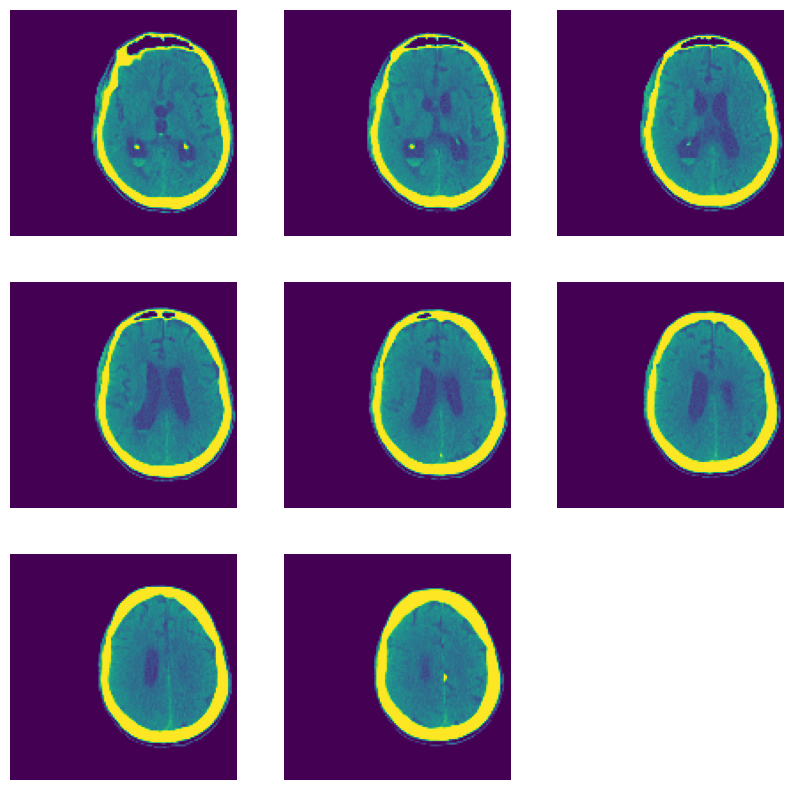

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
  for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    
    plt.axis("off")
  print(labels)

In [10]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, MaxPooling2D, Dense, GlobalAveragePooling2D, Dropout, Flatten
model1 = tf.keras.Sequential()

# glorot_normal means xavier normal initializer
model1.add(Conv2D(input_shape=(128,128,1), kernel_size=(8,8), filters=16, padding='same', use_bias=False, activation="leaky_relu", kernel_initializer='glorot_normal'))
model1.add(BatchNormalization(axis=3))
model1.add(LeakyReLU(alpha=0.1))
model1.add(Conv2D(kernel_size=(6,6), filters=32, padding='valid', use_bias=False, activation="leaky_relu", kernel_initializer='glorot_normal'))
model1.add(BatchNormalization(axis=3))
model1.add(LeakyReLU(alpha=0.1))
model1.add(MaxPooling2D(strides=2, padding='valid'))


#model.add(Dropout(0.2))
model1.add(Dense(32, use_bias=False, activation="leaky_relu", kernel_initializer='glorot_normal'))
model1.add(BatchNormalization(axis=1))
model1.add(LeakyReLU(alpha=0.1))
#model1.add(Dropout(0.2))

model1.add(Dense(1, activation='sigmoid'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      1024      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 123, 123, 32)      18432     
                                                                 
 batch_normalization_1 (Batc  (None, 123, 123, 32)     128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 123, 123, 32)      0

In [11]:
model1.compile(optimizer='adam',    #ustawienie learning rate, optimizera i funkcji straty
              loss='mse',#BinaryCrossentropy(from_logits = False, reduction = 'auto'),
              metrics=['accuracy'])

In [12]:
score = model1.evaluate(train, verbose=1)
print("CNN Error: %.2f%%" % (100-score[1]*100))

: 

: 

In [ ]:
history = model1.fit(train,
                    epochs=5,
                    verbose=1,
                    validation_data = val,
                    #callbacks = [EarlyStop],
                    steps_per_epoch = 193
                   )
 

 
score = model1.evaluate(test, verbose=0)
print("CNN Error: %.2f%%" % (100-score[1]*100))

In [ ]:
import tensorflow
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tensorflow.__version__)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8279153496875034690
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4141875200
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9139354069446900123
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]
2.8.0
